In [ ]:
# ! pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to /Users/cpan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
input_dir = '/Users/cpan/OneDrive - Guardant Health/page_classification_data/'
train_data = pd.read_csv(input_dir + 'train_docs_hir_filter.csv')
valid_data = pd.read_csv(input_dir + 'valid_docs_hir_filter.csv')
test_data = pd.read_csv(input_dir + 'test_docs_hir_filter.csv')

In [3]:
train_data.head()

,file_name,patient_id,page_content,label
0,A0400129_MedRec1/image-003.txt,A0400129,to REDACTED 02 of 10 2021 09 21 19 59 32 gmt 8...,0
1,A0441151_MedRec1/image-023.txt,A0441151,9 27 2022 10 20 am adams jason guardant health...,0
2,A0338434/image-016.txt,A0338434,moffitt cancer 7 26 2021 12 24 02 pm REDACTED ...,0
3,A0395137_MedRec1/image-009.txt,A0395137,uw health 1 12 2022 11 43 12 am page 11 024 fa...,0
4,A0159673_medrec1/image-010.txt,A0159673,2021 12 22 12 32 42 74 391 fields REDACTED a01...,0


In [4]:
train_data['label'].value_counts()

0    1918
1      37
Name: label, dtype: int64

In [5]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, digits, and extra spaces
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Define your custom vocabulary to be added to stopwords
    custom_vocab = ["redacted", "redactedredacted", 'is', 'to', 'of', 'with', 'in', 'no']  # Add your domain-specific terms
    
    # Combine NLTK stopwords and custom vocabulary
    stop_words = set(stopwords.words('english') + custom_vocab)
    
    words = text.split()
    # filter out words that have length less than 2 
    filtered_words = [word for word in words if len(word) > 2 and word not in stop_words]
    text = ' '.join(filtered_words)
    
    return text

# Function to extract BERT embeddings for text data
def extract_bert_features(df):
    embeddings = []
    for text in df['page_content']:
        cleaned_text = clean_text(text)
        inputs = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_pooling = torch.mean(last_hidden_states, dim=1)
        embeddings.append(avg_pooling.squeeze().numpy())
    return np.vstack(embeddings)

In [16]:
# Extract BERT features for train, validation, and test sets
# train_features = extract_bert_features(train_data)
# val_features = extract_bert_features(valid_data)
# test_features = extract_bert_features(test_data)
train_features = np.load(input_dir+'bert_train_features_hir.npy')
val_features = np.load(input_dir+'bert_val_features_hir.npy')
test_features = np.load(input_dir+'bert_test_features_hir.npy')

X_train = train_features
X_val = val_features
X_test = test_features

In [9]:
y_train = train_data['label']
y_val = valid_data['label']

In [10]:
print(y_train.value_counts())

0    1918
1      37
Name: label, dtype: int64


In [11]:
# # Save BERT features to files
# np.save(input_dir+'bert_train_features_hir.npy', train_features)
# np.save(input_dir+'bert_val_features_hir.npy', val_features)
# np.save(input_dir+'bert_test_features_hir.npy', test_features)

In [12]:
# Apply oversampling to the training set since imbalanced data distribution 
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
# not apply resamplling to validation data --> cuz it will introduce bias to the model's generalization 

In [13]:
# # use SMOTE to oversample minority classes 
# smote = SMOTE(sampling_strategy=0.7, k_neighbors=5)  # Adjust k_neighbors as needed
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

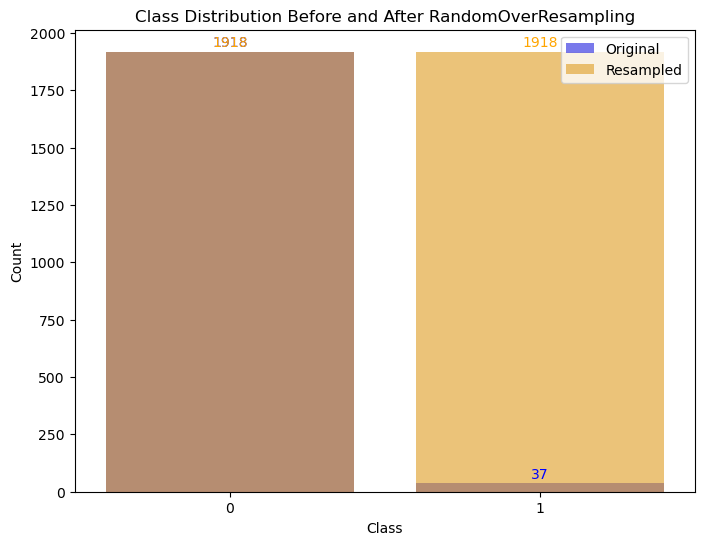

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class in the original and resampled datasets
original_class_counts = y_train.value_counts()
resampled_class_counts = pd.Series(y_train_resampled).value_counts()

# Create a bar plot to visualize class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=original_class_counts.index, y=original_class_counts.values, color='blue', alpha=0.6, label='Original')
sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, color='orange', alpha=0.6, label='Resampled')

# Annotate the bar plots with actual class counts
for index, value in enumerate(original_class_counts.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10, color='blue')

for index, value in enumerate(resampled_class_counts.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10, color='orange')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before and After RandomOverResampling')
plt.legend()
plt.show()

In [17]:
# feature scaling to avoid convergence problem for logistic regression 
# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform features
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Initialize the logistic regression classifier with hyperparameter tuning (L1, L2, and elasticnet regularization)
log_reg_l1 = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='liblinear', max_iter=100, scoring='f1')
log_reg_l2 = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear', max_iter=100, scoring='f1')
log_reg_elasticnet = LogisticRegressionCV(Cs=10, cv=5, penalty='elasticnet', solver='saga', max_iter=100, l1_ratios=[0.5], scoring='f1')

# Perform 5-fold cross-validation with hyperparameter tuning on the combined train and validation data
# cv_scores_l1 = cross_val_score(log_reg_l1, X_val, y_val, cv=5)
# cv_scores_l2 = cross_val_score(log_reg_l2, X_val, y_val, cv=5)
# cv_scores_elasticnet = cross_val_score(log_reg_elasticnet, X_val, y_val, cv=5)

# stratified kfold to deal with imbalanced class distribution data 
# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with hyperparameter tuning on the combined train and validation data
cv_scores_l1 = cross_val_score(log_reg_l1, X_val_scaled, y_val, cv=cv, scoring='f1')
cv_scores_l2 = cross_val_score(log_reg_l2, X_val_scaled, y_val, cv=cv, scoring='f1')
cv_scores_elasticnet = cross_val_score(log_reg_elasticnet, X_val_scaled, y_val, cv=cv, scoring='f1')

# Print cross-validation scores and mean F1 score
print("Cross-Validation F1 Scores (L1):", cv_scores_l1)
print("Mean F1 Score (L1):", np.mean(cv_scores_l1))

print("Cross-Validation F1 Scores (L2):", cv_scores_l2)
print("Mean F1 Score (L2):", np.mean(cv_scores_l2))

print("Cross-Validation F1 Scores (ElasticNet):", cv_scores_elasticnet)
print("Mean F1 Score (ElasticNet):", np.mean(cv_scores_elasticnet))

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_mode

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_mode

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_mode

/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_mode

Cross-Validation F1 Scores (L1): [0. 0. 0. 0. 0.]
Mean F1 Score (L1): 0.0
Cross-Validation F1 Scores (L2): [0.         0.         0.         0.16666667 0.        ]
Mean F1 Score (L2): 0.03333333333333334
Cross-Validation F1 Scores (ElasticNet): [0. 0. 0. 0. 0.]
Mean F1 Score (ElasticNet): 0.0


/Users/cpan/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [19]:
# Choose the best model based on cross-validation F1 scores
X_test = X_test_scaled
y_test = test_data['label']

In [20]:
best_model = log_reg_l2

# Train the best model on the combined training and validation data
best_model.fit(X_train_scaled, y_train_resampled)

# Evaluate the best model on the test set using extracted BERT features
y_pred = best_model.predict(X_test_scaled)

In [21]:
import joblib

In [22]:
joblib.dump(best_model, 'best_fitted_lr_hir_data.pkl')

['best_fitted_lr_hir_data.pkl']

In [23]:
y_pred[:2]

array([0, 0])

In [24]:
y_test[:2]

0    0
1    0
Name: label, dtype: int64

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       411
           1       0.00      0.00      0.00         8

    accuracy                           0.96       419
   macro avg       0.49      0.49      0.49       419
weighted avg       0.96      0.96      0.96       419



In [ ]:
predictions_df = pd.DataFrame({"file_name": test_data["file_name"], 'patient_id': test_data['patient_id'], 'page_content':test_data['page_content'],"is_test": y_pred})

In [ ]:
predictions_df.head()

In [ ]:
print(predictions_df.shape)
predictions_df['is_test'].value_counts()

In [26]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_true contains the true labels and y_pred contains the predicted labels
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Precision: 0.0
Recall: 0.0
F1-Score: 0.0


In [27]:
# predictions_df.to_csv(input_dir+'predicted_test_results_lr_hir_data.csv', index=False)

### Error Analysis 

In [ ]:
from sklearn.metrics import confusion_matrix

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Find indices of misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]

# Print some of the misclassified examples for analysis
num_examples_to_print = 5
print("\nMisclassified Examples:")
for i in range(min(num_examples_to_print, len(misclassified_indices))):
    index = misclassified_indices[i]
    print(f"Example {i+1}:")
    print("True Label:", y_test.iloc[index])
    print("Predicted Label:", y_pred[index])
    print("Text:")
    print(test_data['page_content'].iloc[index])
    print("="*50)

# Analyze common words or phrases in misclassified examples
misclassified_text = test_data['page_content'].iloc[misclassified_indices]
miclassified_text_clean = [clean_text(text) for text in misclassified_text]
common_words = {}
for text in miclassified_text_clean:
    words = text.split()
    for word in words:
        if word not in common_words:
            common_words[word] = 1
        else:
            common_words[word] += 1

# Print most common words in misclassified examples
print("Common Words in Misclassified Examples:")
sorted_common_words = sorted(common_words.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_common_words[:10]:
    print(f"{word}: {count}")

# Additional analysis could involve checking if there are specific types of pages (e.g., medical, technical) that the model struggles with,
# and using this information to fine-tune features or the model itself.

In [ ]:
print(len(misclassified_indices))

In [ ]:
# import re

# # Initialize a counter for occurrences of "guardant" or its part
guardant_count = 0

# Analyze common words or phrases in misclassified examples
misclassified_text = test_data['page_content'].iloc[misclassified_indices]
misclassified_text_clean = [clean_text(text) for text in misclassified_text]

for text in misclassified_text_clean:
    if re.findall(r'\bguardant\b', text):  # Using \b to match whole word "guardant"
        guardant_count += 1

# Print the number of misclassified examples containing "guardant" or its part
print("Number of Misclassified Examples Containing 'guardant':", guardant_count)


In [ ]:
# # data filtering 
import re

# List of competitor test names (not converted to lowercase)
company_test_list = ['FoundationOne Liquid', 'Plasma Focus', 'Liquid Hallmark', 'Genestrat, InVisionFirst-Lung',
                     'FoundationOne CDx', 'Caris Molecular Intelligence', 'OncoExtra', 'Altera', 'Invitae Cancer Screen', 'MyRisk']
not_lower_company_test_list = ['xF', 'xF+', 'Assure', 'xT']

# Create a copy of the predictions DataFrame to avoid modifying the original one
filtered_predictions_df = predictions_df.copy()

# Iterate through each row in the DataFrame
for index, row in filtered_predictions_df.iterrows():
    text_content = row['page_content']
    predicted_test = row['is_test']
    
    # Use re.findall to find partial matches for "guardant" (case-insensitive)
    guardant_matches = re.findall(r'guardant', text_content, re.IGNORECASE)
    
    # Check if the guardant_matches list is not empty and if the predicted test is 1
    if guardant_matches and predicted_test == 1:
        # Check if any competitor's test name is present in the text content (not converted to lowercase)
        if not any(spec_test in text_content for spec_test in not_lower_company_test_list):
            # Change the predicted label to 0
            filtered_predictions_df.at[index, 'is_test'] = 0
        if not any(test.lower() in text_content.lower() for test in company_test_list):
            filtered_predictions_df.at[index, 'is_test'] = 0

# Assuming y_true contains the true labels and filtered_predictions_df contains the modified predicted labels
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, filtered_predictions_df['is_test'], average='binary')

print("Precision after filtering:", precision)
print("Recall after filtering:", recall)
print("F1-Score after filtering:", f1_score)